In [2]:
3e-3 / np.sqrt((3e-3)**2 + (1.5e-3)**2)

0.8944271909999159

In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from inxss import SpectrumDataset, SpecNeuralReprDropout, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt

from tqdm import tqdm 

import os
from datetime import datetime
from omegaconf import DictConfig, OmegaConf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

with initialize(config_path="conf/final"):
    cfg = compose(config_name="config_poisson_uq")

/tmp/ipykernel_908251/1332241837.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="conf/final"):


In [3]:
num_steps = cfg['general']['num_steps']

scale_likelihood = cfg['likelihood']['scale']
likelihood_type = cfg['likelihood']['type']


time_stamp = datetime.now().strftime("%Y%m%d-%H%M")
if cfg['likelihood']['type'] == 'gaussian':
    output_path = os.path.join(
        cfg['paths']['output_path'],
        f"EXP_lkhd_{likelihood_type}_std_{cfg['likelihood']['std']}_scaled_{scale_likelihood}_steps_{num_steps}_{time_stamp}"
    )
else:
    output_path = os.path.join(
        cfg['paths']['output_path'],
        f"EXP_lkhd_{likelihood_type}_scaled_{scale_likelihood}_steps_{num_steps}_{time_stamp}"
    )
if not os.path.exists(output_path):
    os.makedirs(output_path)
print('output_path:', output_path)

OmegaConf.save(cfg, os.path.join(output_path, "config.yaml"))

output_path: /pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/EXP_lkhd_poisson_scaled_True_steps_50_20240916-1909


In [4]:
model_path = cfg['paths']['model_path']
data = torch.load(cfg['paths']['data_path'])
print(data.keys())

dict_keys(['grid', 'S', 'background', 'background_dict'])


In [5]:
[(data['grid'][k].min(), data['grid'][k].max()) for k in data['grid'].keys()]

[(tensor(-2., dtype=torch.float64), tensor(2., dtype=torch.float64)),
 (tensor(-2., dtype=torch.float64), tensor(2., dtype=torch.float64)),
 (tensor(-10., dtype=torch.float64), tensor(4.5000, dtype=torch.float64)),
 (tensor(20., dtype=torch.float64), tensor(200., dtype=torch.float64))]

In [6]:
data['grid']['w_grid'].shape

torch.Size([91])

### setup experiment simulator

In [7]:
from inxss.experiment import Background

In [8]:
background = Background(
    tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), 
    data['grid']['w_grid'], 
    data['background']
)

### Testing integrated steer module

In [9]:
from inxss.steer_neutron import NeutronExperimentSteerer

In [10]:
if 'particle_filter' in cfg:
    particle_filter_config = OmegaConf.to_container(cfg['particle_filter'], resolve=True)
    print('loading particle filter from config file...')
    print(particle_filter_config)
else:
    particle_filter_config = {
        "num_particles": 1000,
        "dim_particles": 2,
        "prior_configs": {'types': ['uniform', 'uniform'], 'args': [{'low': 20, 'high': 40}, {'low': -5, 'high': 5}]}
    }

Particle(**particle_filter_config)

Particle()

In [11]:


grid_info = {
    'h_grid': [-2.0, 2.0, 121],
    'k_grid': [-2.0, 2.0, 121],
    'l_grid': [-10.0, 4.5, 30],
    'w_grid': [20.0, 200.0, 91]
}
# grid_info = {
#     _: [eval(f'neutron_exp.{_}').min().item(), eval(f'neutron_exp.{_}').max().item(), eval(f'neutron_exp.{_}').shape[0]] 
#     for _ in ['h_grid', 'k_grid', 'l_grid', 'w_grid']}

mask_config = {
    "raw_mask_path": cfg['paths']['raw_mask_path'],
    "memmap_mask_path": cfg['paths']['memmap_mask_path'],
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": True,
    "global_mask": data['S']>0
}

if hasattr(cfg, 'experiment_config'):
    _experiment_config = OmegaConf.to_container(cfg['experiment_config'], resolve=True)
    print('loading experiment config from config file...')
    print(_experiment_config)
    experiment_config = {
        "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
        "w_grid": data['grid']['w_grid'],
        "S_grid": data['S'],
        "S_scale_factor": _experiment_config["S_scale_factor"],
        "poisson": _experiment_config["poisson"]
    }
else:
    experiment_config = {
        "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
        "w_grid": data['grid']['w_grid'],
        "S_grid": data['S'],
        "S_scale_factor": 1.,
        "poisson": False
    }

background_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "bkg_grid": data['background']
}

model = SpecNeuralReprDropout.load_from_checkpoint(model_path).to(device)

steer = NeutronExperimentSteerer(
    model, particle_filter_config=particle_filter_config,
    mask_config=mask_config, experiment_config=experiment_config, background_config=background_config,
    use_utility_sf=cfg['utility']['use_utility_sf'], utility_sf_sigma=cfg['utility']['utility_sf_sigma'],
    tqdm_pbar=False, lkhd_dict=cfg['likelihood'], device='cuda')

obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_200.0_91.npy


In [12]:
steer.reset()

mean_list = [steer.particle_filter.mean().detach().cpu().clone()]
std_list = [steer.particle_filter.std().detach().cpu().clone()]

posisition_list = [steer.particle_filter.positions.data.T[None].cpu().clone()]
weights_list = [steer.particle_filter.weights.data[None].cpu().clone()]

In [13]:
# num_pixels = []
# for angle in tqdm(steer.psi_mask.psi_grid):
#     num_pixels.append(steer.psi_mask.load_memmap_mask(angle).sum().item())
# plt.plot(steer.psi_mask.psi_grid, num_pixels)

In [14]:
if not 'steer' in cfg:
    steer_mode = 'unique_optimal'
    angles = [None,] * num_steps
else:
    if cfg['steer']['mode'] == 'sequential':
        steer_mode = 'custom'
        angles = np.round(np.linspace(cfg['steer']['start'], cfg['steer']['end'], num_steps))
    elif cfg['steer']['mode'] == 'random':
        steer_mode = 'custom'
        angles = np.round(np.linspace(cfg['steer']['start'], cfg['steer']['end'], num_steps))
        np.random.shuffle(angles)
    else:
        steer_mode = cfg['steer']['mode']

print("steer mode: ", steer_mode)
print("angles: \n", angles)

steer mode:  unique_optimal
angles: 
 [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [15]:
steer.experiment.Sqw.max()

tensor(132.2341, dtype=torch.float64)

In [16]:
record_steps = [0, num_steps//4, num_steps//2, 3*num_steps//4, num_steps-1]
record_particle = {}

with torch.no_grad():
    progress_bar = tqdm(range(num_steps))
    for i in progress_bar:
        steer.step_steer(mode=steer_mode, next_angle=angles[i])
        current_mean = steer.particle_filter.mean().detach().cpu()
        current_std = steer.particle_filter.std().detach().cpu()
        progress_bar.set_description(
            f'means: [{current_mean[0]:.3f}, {current_mean[1]:.3f}] '
            f' stds: [{current_std[0]:.3f}, {current_std[1]:.3f}]'
        )
        mean_list.append(current_mean.clone())
        std_list.append(current_std.clone())

        posisition_list.append(steer.particle_filter.positions.data.T[None].cpu().clone())
        weights_list.append(steer.particle_filter.weights.data[None].cpu().clone())
        
        

means: [29.135, 1.781]  stds: [0.837, 0.581]: 100%|██████████| 50/50 [12:46<00:00, 15.33s/it]


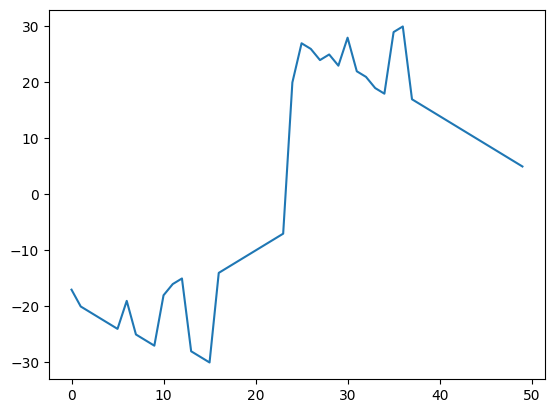

In [17]:
measured_angles = np.vstack(steer.measured_angles_history).squeeze()
measured_angles[measured_angles > 180] -= 360
plt.plot(measured_angles)

In [18]:
from inxss.utils_visualization import visualize_utility

<PolarAxes: >

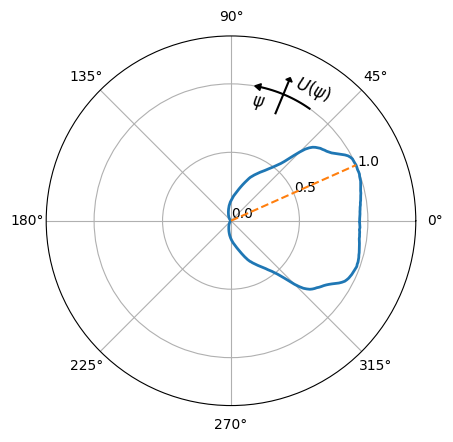

In [19]:
visualize_utility(steer.psi_mask.psi_grid, steer.utility_history[-1])

In [20]:
means = torch.vstack(mean_list).detach().numpy()[:]
std_dev = torch.vstack(std_list).detach().numpy()[:]

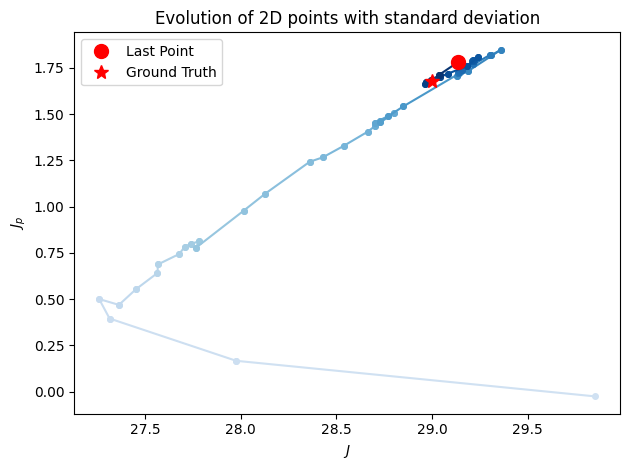

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create some dummy data
scale_factor = 0.25
N = means.shape[0]
# means = np.cumsum(np.random.randn(N, 2), axis=0)
# stds = np.abs(np.random.randn(N, 2))

# Visualization
fig, ax = plt.subplots()

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0.2, 1, N)]

# Plot the evolution of the points with colormap
for i in range(N-1):
    ax.plot(means[i:i+2, 0], means[i:i+2, 1], '-o', color=colors[i], markersize=4)
ax.plot(means[-1,0], means[-1,1], 'o', label='Last Point', markersize=10, color='red')
ax.plot(29.0, 1.68, '*', label='Ground Truth', markersize=10, color='red')

ax.set_title('Evolution of 2D points with standard deviation')
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
# ax.set_xlim(20, 40)
# ax.set_ylim(-5, 5)
ax.legend()

plt.tight_layout()
plt.show()


(-1.0, 52.0)

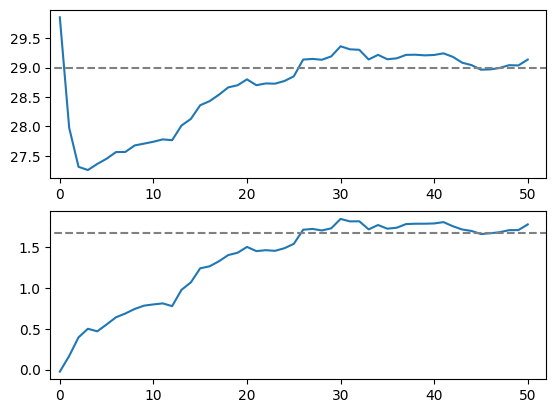

In [22]:
fig, ax = plt.subplots(2,1)
ax[0].plot(means[:,0])
ax[0].hlines([29.0,], -10, len(means)+10, color='gray', linestyle='--') 
ax[1].plot(means[:,1])
ax[1].hlines([1.68,], -10, len(means)+10, color='gray', linestyle='--')
ax[0].set_xlim([-1, len(means)+1])
ax[1].set_xlim([-1, len(means)+1])


registered cmap: seaborn_cubehelix



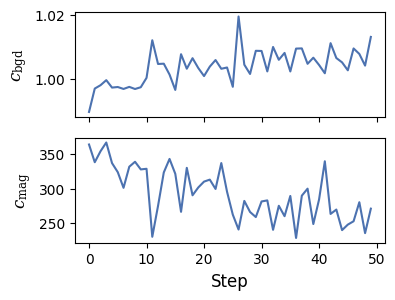

In [23]:
try:
    from paper_preperation.config_matplotlib import config_matplotlib
    config_matplotlib()
except:
    pass


fig, axes = plt.subplots(2, 1, figsize=(4,3), sharex=True)
axes[0].plot(torch.stack(steer.sig_bkg_factors_history).numpy()[:,0])
axes[1].plot(torch.stack(steer.sig_bkg_factors_history).numpy()[:,1])

axes[1].set_xlabel('Step')
axes[1].set_ylabel('$c_{\mathrm{mag}}$')
axes[0].set_ylabel('$c_{\mathrm{bgd}}$')
fig.savefig('paper_preperation/figures/sig_bkg_factors.pdf', bbox_inches='tight')

In [24]:
from inxss import linspace_2D_equidistant, plot_points, get_Sqw_func

kpt_labels = ['$\mathrm{P}$', '$\mathrm{M}$', '$\mathrm{X}$', '$\mathrm{P}$', '$\Gamma$', '$\mathrm{X}$']

# kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
kpts = torch.from_numpy(linspace_2D_equidistant([[1/4,1/4], [1/2,1/2], [0,1/2], [1/4,1/4], [0,0], [0,1/2]], 100))
_, kpt_indices = linspace_2D_equidistant([[1/4,1/4], [1/2,1/2], [0,1/2], [1/4,1/4], [0,0], [0,1/2]], 100, return_indices=True)
wpts = steer.experiment.w_grid

qw_coords = []
for _l in steer.experiment.l_grid:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)

In [25]:
S_exp = 0.
for _qw_coords in qw_coords:
    S_exp += steer.experiment.get_measurements_on_coords(_qw_coords)

In [26]:
params = steer.particle_filter.mean()
# params = torch.tensor([29, 1.7])
x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
x[...,:3] = torch.cat([
    kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
    wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
   ], dim=2)
x[...,3:] = params

model.eval()
S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()

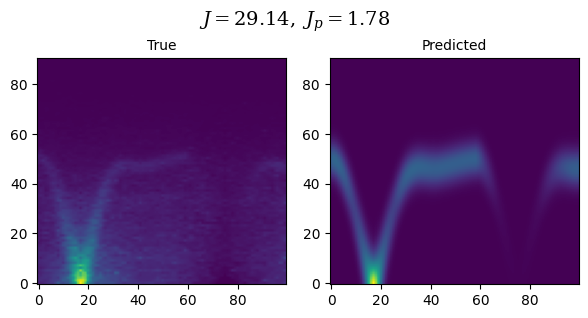

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(S_exp, origin='lower')
ax[0].set_title('True')
ax[1].imshow(S_pred, origin='lower')
ax[1].set_title('Predicted')

fig.suptitle(rf'$J={params[0]:.2f}, \ J_{{p}}={params[1]:.2f}$')
fig.tight_layout()
# fig.savefig(f"test_idx_{idx_plot}.svg", bbox_inches='tight')

In [28]:
import seaborn as sns

In [29]:

from paper_preperation.config_matplotlib import config_matplotlib
config_matplotlib()


registered cmap: seaborn_cubehelix



In [30]:
from sklearn.neighbors import KernelDensity

def kde_particle_to_grid(positions, weights, kde_kwargs=None):
    if kde_kwargs is None:
        kde_kwargs = {'kernel': 'gaussian', 'bandwidth': 0.5}
    kde = KernelDensity(**kde_kwargs).fit(positions, sample_weight=weights)
    J, Jp = np.meshgrid(np.linspace(20, 40, 401), np.linspace(-5, 5, 201))
    param_grid = np.concatenate([J[..., None], Jp[..., None]], axis=-1)
    log_density = kde.score_samples(param_grid.reshape(-1, 2)).reshape(J.shape)
    density = np.exp(log_density)
    return density, J, Jp


In [31]:
# kde_density, J_grid, Jp_grid = kde_particle_to_grid(posisition_list[step_for_plot].squeeze(), weights_list[step_for_plot].squeeze())

In [114]:
step_for_plot = 0

In [115]:
idx_particle = np.random.choice(steer.particle_filter.num_particles, size=100, replace=True, p=weights_list[step_for_plot].squeeze().numpy())

In [116]:
steer.model.eval()

S_pred_uq_param = []

for _idx_particle in idx_particle:
    
    params = posisition_list[step_for_plot].squeeze()[_idx_particle]
    
    x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
    x[...,:3] = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
    ], dim=2)
    x[...,3:] = params

    S_pred_uq_param.append(steer.model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy())
    
S_pred_uq_param = np.array(S_pred_uq_param)


In [117]:
steer.model.train()

S_pred_uq_nn = []

for i in range(len(idx_particle)):
    
    params = mean_list[step_for_plot]
    x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
    x[...,:3] = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
    ], dim=2)
    x[...,3:] = params
    
    S_pred_uq_nn.append(steer.model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy())
    
S_pred_uq_nn = np.array(S_pred_uq_nn)

In [118]:
cmap = sns.color_palette("magma", as_cmap=True)

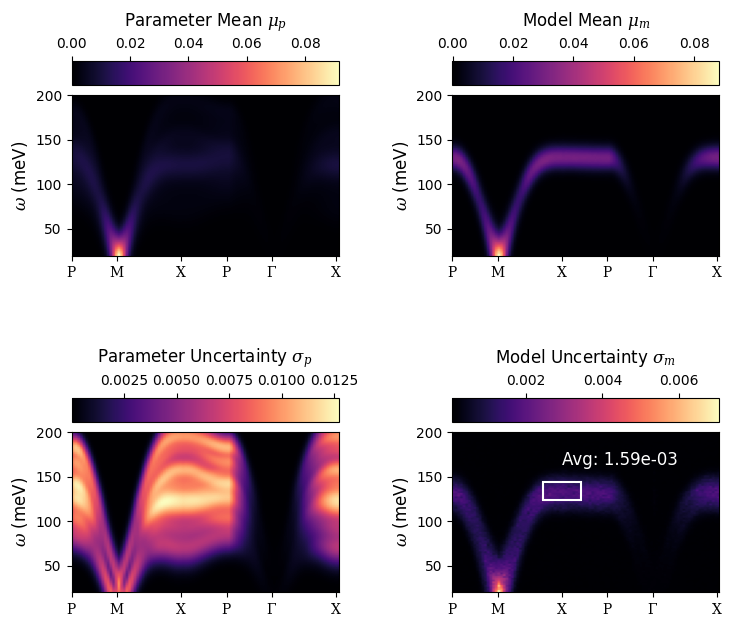

In [119]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

# First plot
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(S_pred_uq_param.mean(axis=0), origin='lower', cmap=cmap, 
                 extent=[0, len(kpts), wpts.min(), wpts.max()])
ax1.set_aspect(1/3)
ax1.set_ylabel('$\omega$ (meV)')
ax1.set_xticks(kpt_indices)
ax1.set_xticklabels(kpt_labels)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('top', size='5%', pad=-1.5)
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position('top')
# cax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_title('Parameter Mean $\mu_{{p}}$', pad=50, fontsize=12)

# Second plot
ax2 = fig.add_subplot(gs[1, 0])
im2 = ax2.imshow(S_pred_uq_param.std(axis=0), origin='lower', cmap=cmap, 
                 extent=[0, len(kpts), wpts.min(), wpts.max()])
ax2.set_aspect(1/3)
ax2.set_ylabel('$\omega$ (meV)')
ax2.set_xticks(kpt_indices)
ax2.set_xticklabels(kpt_labels)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('top', size='5%', pad=-1.5)
cb2 = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cax2.xaxis.set_ticks_position('top')
ax2.set_title('Parameter Uncertainty $\sigma_{{p}}$', pad=50, fontsize=12)

# Third plot
ax3 = fig.add_subplot(gs[0, 1])
im3 = ax3.imshow(S_pred_uq_nn.mean(axis=0), origin='lower', cmap=cmap, 
                 extent=[0, len(kpts), wpts.min(), wpts.max()])
ax3.set_aspect(1/3)
ax3.set_ylabel('$\omega$ (meV)')
ax3.set_xticks(kpt_indices)
ax3.set_xticklabels(kpt_labels)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('top', size='5%', pad=-1.5)
cb3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cax3.xaxis.set_ticks_position('top')
# cax3.xaxis.set_major_locator(plt.MaxNLocator(5))
ax3.set_title('Model Mean $\mu_{{m}}$', pad=50, fontsize=12)

# Fourth plot
ax4 = fig.add_subplot(gs[1, 1])
im4 = ax4.imshow(S_pred_uq_nn.std(axis=0), origin='lower', cmap=cmap, 
                 extent=[0, len(kpts), wpts.min(), wpts.max()])
ax4.set_aspect(1/3)
ax4.set_ylabel('$\omega$ (meV)')
ax4.set_xticks(kpt_indices)
ax4.set_xticklabels(kpt_labels)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('top', size='5%', pad=-1.5)
cb4 = fig.colorbar(im4, cax=cax4, orientation='horizontal')
cax4.xaxis.set_ticks_position('top')

roi_x = kpt_indices[2]-7  # Top-left corner of the ROI
roi_width = 14  # Width and height of the ROI
roi_y = np.argmax(S_pred_uq_nn.std(axis=0)[:, roi_x: roi_x+roi_width].mean(axis=-1))-5
roi_height = 10
roi_data = S_pred_uq_nn.std(axis=0)[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]
roi_avg = np.mean(roi_data)
# Add a rectangle for the ROI
rect = patches.Rectangle((roi_x, wpts[roi_y]), roi_width, wpts[roi_y+roi_height]-wpts[roi_y], linewidth=1.5, edgecolor='w', facecolor='none')
ax4.add_patch(rect)
# Display the average beside the rectangle
ax4.text(roi_x + roi_width / 2, wpts[roi_y + roi_height] + 25, f'Avg: {roi_avg:.2e}', color='white', fontsize=12, 
        verticalalignment='center')
ax4.set_title('Model Uncertainty $\sigma_{{m}}$', pad=50, fontsize=12)

# cax4.xaxis.set_major_locator(plt.MaxNLocator(5))

# Ensure tight layout with GridSpec
plt.tight_layout()
plt.show()
fig.savefig(f'paper_preperation/figures/model_uq/exp_step_{step_for_plot}_uq.pdf', bbox_inches='tight')

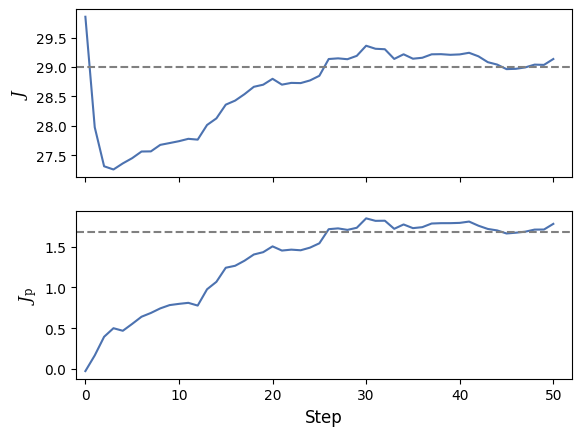

In [124]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(means[:,0])
ax[0].hlines([29.0,], -10, len(means)+10, color='gray', linestyle='--') 
ax[0].set_ylabel('$J$')
ax[1].plot(means[:,1])
ax[1].hlines([1.68,], -10, len(means)+10, color='gray', linestyle='--')
ax[0].set_xlim([-1, len(means)+1])
ax[1].set_xlim([-1, len(means)+1])
ax[1].set_xlabel('Step')
ax[1].set_ylabel('$J_{\mathrm{p}}$')

fig.savefig('paper_preperation/figures/model_uq/mean_trajectory.pdf', bbox_inches='tight')

In [125]:
kde_dict = {}
kde_dict['kde'] = {}
for step in [0, 10, 20, 30, 40, 50]:
    _kde, J_grid, Jp_grid = kde_particle_to_grid(posisition_list[step].squeeze(), weights_list[step].squeeze())
    kde_dict['kde'][step] = _kde

kde_dict['J_grid'] = J_grid
kde_dict['Jp_grid'] = Jp_grid

/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


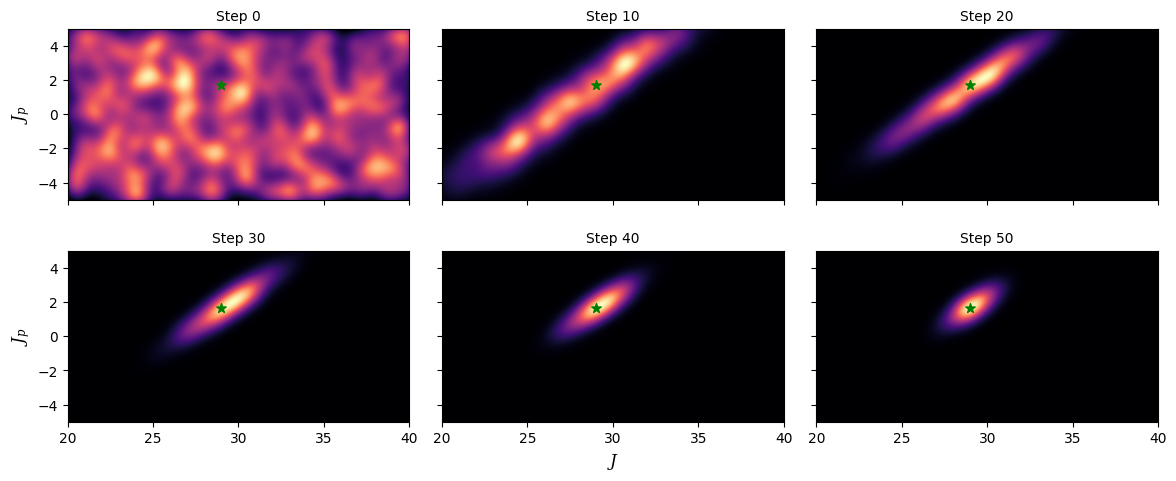

In [144]:
fig, ax = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)
for i, step in enumerate([0, 10, 20, 30, 40, 50]):
    ax[i//3, i%3].imshow(kde_dict['kde'][step], origin='lower', cmap=cmap, 
                         extent=[20, 40, -5, 5])
    ax[i//3, i%3].set_aspect(1)
    ax[i//3, i%3].set_xticks([20, 25, 30, 35, 40])
    ax[i//3, i%3].set_title(f'Step {step}')
    if i//3 == 1 and i%3 == 1:
        ax[i//3, i%3].set_xlabel('$J$')
    # ax[i//3, i%3].set_xlabel('$J$')
    if i%3 == 0:
        ax[i//3, i%3].set_ylabel('$J_{p}$')
    ax[i//3, i%3].scatter([29.0,], [1.68,], color='g', marker='*', s=50)
    # ax[i//3, i%3].hlines([1.68,], 20, 40, color='gray', linestyle='--')
    # ax[i//3, i%3].vlines([29.0,], -5, 5, color='gray', linestyle='--')
plt.tight_layout()
fig.savefig('paper_preperation/figures/model_uq/kde_profiles.pdf', bbox_inches='tight')

In [126]:
# torch.save(
#     {
#         'mean_list': mean_list,
#         'std_list': std_list,
#         'posisition_list': posisition_list,
#         'weights_list': weights_list,
#         'kde_dict': kde_dict
#     },
#     'outputs/model_uq_results.pt'
# )